# Space-time visualisations (giddy)

In [41]:
import libpysal.api as lp
from libpysal import examples
import libpysal.io.geotable as pdio
import numpy as np
import pandas as pd
import geopandas as gpd
from giddy.directional import Rose
import matplotlib.pyplot as plt
from splot import plot
import esda
from splot.bk import lisa_cluster
from bokeh.io import show
import seaborn as sns
from splot.mpl import lisa_cluster
from splot._viz_utils import moran_hot_cold_spots

from ipywidgets import interact, fixed
import ipywidgets as widgets

%matplotlib inline

# Data preparation

In [27]:
# get csv and shp and merge
shp_link = examples.get_path('us48.shp')
df = gpd.read_file(shp_link)
income_table = pd.read_csv(examples.get_path("usjoin.csv"))

In [28]:
# calculate relative values
for year in range(1969, 2010):
    income_table[str(year) + '_rel'] = income_table[str(year)] / income_table[str(year)].mean()

In [29]:
# merge
gdf = df.merge(income_table,left_on='STATE_NAME',right_on='Name')

In [30]:
#calculate weights and moran_loc
w = lp.Queen.from_dataframe(gdf)
w.transform = 'r'
y1 = gdf['1969_rel'].values
y2 = gdf['2000_rel'].values
moran_loc1 = esda.moran.Moran_Local(y1, w)
moran_loc2 = esda.moran.Moran_Local(y2,w)

# Plotting

## Heatmap

In [86]:
def fig_space_time_heatmap(y1, y2, moran_loc1, moran_loc2, p=0.05, ax=None):
    cluster = moran_hot_cold_spots(moran_loc1, p=p)
    cluster2 = moran_hot_cold_spots(moran_loc2, p=p)

    # to put into seaborn function
    # and set diagonal elements to zero to see the rest better
    heatmap_data = np.zeros((5, 5), dtype=int)
    mask = np.zeros((5, 5), dtype=bool)
    for row in range(5):
        for col in range(5):
            yr1 = cluster == row
            yr2 = cluster2 == col
            heatmap_data[row, col] = (yr1 & yr2).sum()
            if row == col:
                mask[row, col] = True

    # set name for tick labels
    xticklabels = ['ns', 'HH', 'HL', 'LH', 'LL'] 
    yticklabels = ['ns', 'HH', 'HL', 'LH', 'LL']  

    fig = sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu",
                xticklabels=xticklabels, yticklabels=yticklabels,
                mask=mask, center=20, ax=ax, cbar=False, square=True)
    return fig

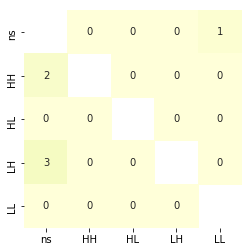

In [87]:
space_time_heatmap(y1, y2, moran_loc1, moran_loc2)
plt.show()

## static space time autocorrelation

In [88]:
def space_time_correl(gdf, timex, timey,
                      p=0.05, figsize=(13,10)):
    
    #prepare data for plotting:
    w = lp.Queen.from_dataframe(gdf)
    w.transform = 'r'
    y1 = gdf[timex].values
    y2 = gdf[timey].values
    
    # Moran_Local uses random numbers, which we cannot change between the two years!
    old_state = np.random.get_state()
    moran_loc1 = esda.moran.Moran_Local(y1, w)
    np.random.set_state(old_state)
    moran_loc2 = esda.moran.Moran_Local(y2, w)
    np.random.set_state(old_state)

    fig = plt.figure(figsize=figsize)
    fig.suptitle('Space-time autocorrelation', fontsize=20)
    axs = []
    axs.append(plt.subplot(221))
    axs.append(plt.subplot(222))
    axs.append(plt.subplot(223, projection='polar'))
    axs.append(plt.subplot(224))
    
    # space_time_heatmap
    fig = space_time_heatmap(y1, y2, moran_loc1, moran_loc2, p=p, ax=axs[0])
    fig.xaxis.set_ticks_position('top')
    fig.set_xlabel(timex)
    fig.xaxis.set_label_position('top')
    fig.set_ylabel(timey)

    # Lisa_clusters
    lisa_cluster(moran_loc1, gdf, p=p, ax=axs[1], legend=True,
                 legend_kwds={'loc': 'upper left',
                 'bbox_to_anchor': (0.92, 1.05)})
    lisa_cluster(moran_loc2, gdf, p=p, ax=axs[3], legend=True,
                 legend_kwds={'loc': 'upper left',
                 'bbox_to_anchor': (0.92, 1.05)})

    # Rose diagram: Moran movement vectors:
    Y = np.array([y1, y2]).T
    print(Y.shape)

    rose = Rose(Y, w, k=5)
    rose.plot(ax=axs[2])
    #rose.plot(attribute=Y[:,0], ax=axs[2]) # colorbar placement is messed up
    
    return fig

(48, 2)


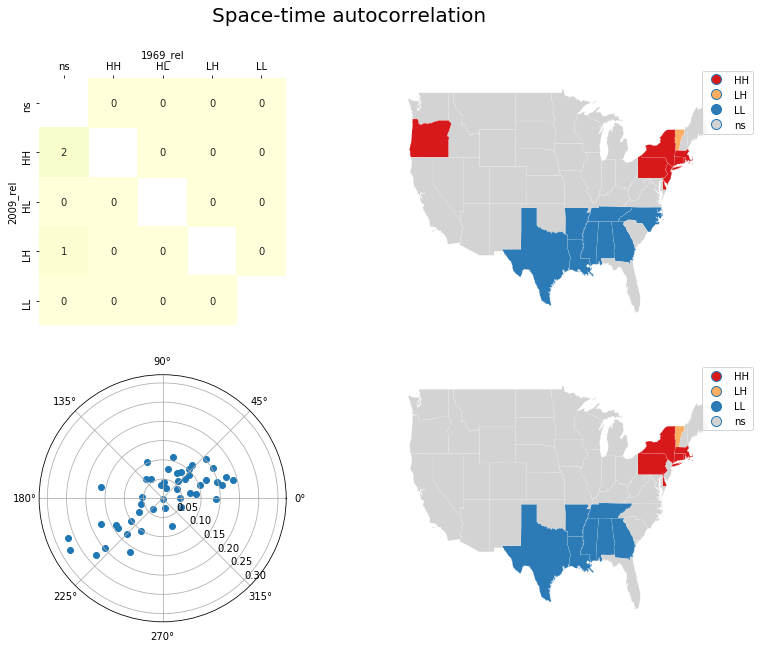

In [89]:
space_time_autocorrelation(gdf, timex='1969_rel', timey='2009_rel')
plt.show()

## Interactive space time autocorrelation

In [90]:
def space_time_correl_interactive(gdf, pattern='_rel', p=0.05, figsize=(13,10)):    
    #interact(moran_loc_gdf, timex=widgets.IntSlider(min=int(timex),max=int(timey),step=1,value=1969_rel),
    #         timey=widgets.IntSlider(min=1969_rel,max=2009_rel,step=1,value=2009_rel),
    #        gdf=fixed(gdf))
    coldict = {col: col for col in gdf.columns if col.endswith(pattern)}
    interact(space_time_autocorrelation,
             timex=coldict, timey=coldict, gdf=fixed(gdf), p=fixed(p), figsize=fixed(figsize))

In [91]:
space_time_autocorrelation_interactive(gdf, '_rel')

interactive(children=(Dropdown(description='timex', options={'1969_rel': '1969_rel', '1970_rel': '1970_rel', '…

## IDEAS

In [ ]:
def moran_loc_gdf(timex, timey, gdf):
    #wrapper function of interactive autocorrelation
    '''w = lp.Queen.from_dataframe(gdf)
    w.transform = 'r'
    y1 = gdf[str(timex)].values
    y2 = gdf[str(timey)].values
    # Moran_Local uses random numbers, which we cannot change between the two years!
    old_state = np.random.get_state()
    moran_loc1 = esda.moran.Moran_Local(y1, w)
    np.random.set_state(old_state)
    moran_loc2 = esda.moran.Moran_Local(y2, w)
    np.random.set_state(old_state)'''
    space_time_autocorrelation(gdf=gdf, timex=timex, timey=timey)